## Food Vision Big Project

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from helper_function import create_tensorboard_callback, plot_loss_curve, compare_history
import os
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
import numpy as np

### Setup mixed precision training
It is the technique which use 16-bit floating-point (float16) precision for some parts of the neural network while keeping other parts in 32-bit floating-point (float32) precision. This can speed up training and reduce memory usage without significantly sacrificing model accuracy.

In [2]:
### This laptop don`t have gpu, hence it is not working

# mixed_precision.set_global_policy(policy = "mixed_float16")
# mixed_precision.global_policy()

In [3]:
mixed_precision.global_policy()

<Policy "float32">

### 1. Data preparation

In [4]:
### Get all available datasets in TFDS

datasets_list = tfds.list_builders()

In [5]:
### Check if the dataset exist

target_dataset = "food101"

print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [6]:
(train_data, test_data), ds_info = tfds.load(
    name = "food101", # Dataset name
    split = ["train", "validation"], # What kind of split data should we have? Not all dataset have train, valid and test.
    shuffle_files = True, # Shuffle file while downloading
    as_supervised = True, # Download data in tuple format (sample, label), example: (image, label)
    with_info = True) # Include dataset metadata

In [7]:
### Features of Food101 TFDS

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
### All class name of Food101

class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
### Take one sample from training data and explore it

train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
### Output info of one training sample

for image, label in train_one_sample:
    print(f"""Image shape: {image.shape}, Image dtype: {image.dtype}, Target class from Food101 (tensor form): {label}
       Class name (str form): {class_names[label.numpy()]}""")

Image shape: (512, 512, 3), Image dtype: <dtype: 'uint8'>, Target class from Food101 (tensor form): 77
       Class name (str form): pork_chop


In [11]:
### Image in tensor form

image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [12]:
### Min and max value of image

print(f"min: {tf.reduce_min(image)}, max: {tf.reduce_max(image)}")

min: 0, max: 255


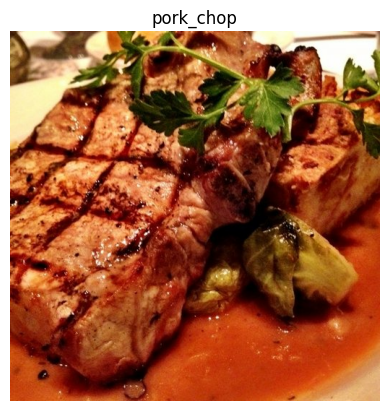

In [13]:
### Visualization of image tensor

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [14]:
### Convert uint8 > float32
### Resize to (224, 224, 3)
### Scale/ normalize 0 - 255 to 0 - 1

def preprocess_image(image, label, img_shape = 224):
    image = tf.image.resize(image, [img_shape, img_shape])

    return tf.cast(image, tf.float32), label

In [15]:
preprocessed_image = preprocess_image(image, label)[0]

print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_image[:2]}...,\nShape: {preprocessed_image.shape},\nDatatype: {preprocessed_image.dtype}")

Image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


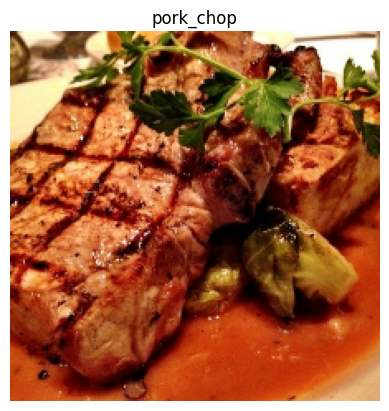

In [16]:
### Plot preprocessed image by divided by 255 

plt.imshow(preprocessed_image/ 255.)
plt.title(class_names[label])
plt.axis(False);

In [17]:
train_data = train_data.map(map_func = preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

### 2. Model building

In [18]:
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor = "val_accuracy",
    save_best_only = True, save_weights_only = True, verbose = 0)

In [19]:
### With mix precision

# mixed_precision.set_global_policy(policy = "mixed_float16")

# input_shape = (224, 224, 3)

# base_model = tf.keras.applications.EfficientNetB0(include_top = False)
# base_model.trainable = False

# input_layer = layers.Input(shape = input_shape, name = "input_layer")

# x = base_model(input_layer, training = False)
# x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
# x = layers.Dense(len(class_names))(x)
#### Separate activation of output layer so we can output float32 activation
# output_layer = layers.Activation("softmax", dtype = tf.float32, name = "output_layer")(x)

# model = tf.keras.Model(input_layer, output_layer)

# model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
#     metrics = ["accuracy"])

# model.summary()

First model - EfficientNetB0 (Feature Extraction)

In [20]:
### Without mix precision

input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

input_layer = layers.Input(shape = input_shape, name = "input_layer")

x = base_model(input_layer, training = False)
x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)

output_layer = layers.Dense(len(class_names), activation = "softmax")(x)

first_model = tf.keras.Model(input_layer, output_layer)

first_model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [21]:
### Check layer of model

for layer in first_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">


In [22]:
### Check the first 20 layers of EfficientNetB0

for layer in first_model.layers[1].layers[:20]: 
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
rescaling_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [23]:
first_model_history = first_model.fit(train_data, epochs = 3, steps_per_epoch = len(train_data), 
    validation_data = test_data, validation_steps = int(0.15 * len(test_data)),
    callbacks = [create_tensorboard_callback("model_log", "efficientnetb0_101_classes_all_data_feature_extraction"),
            model_checkpoint])

Saving TensorBoard log files to: model_log/efficientnetb0_101_classes_all_data_feature_extraction/20230929-183626
Epoch 1/3
2368/2368 [==============================] - 2679s 1s/step - loss: 1.7185 - accuracy: 0.5838 - val_loss: 1.1237 - val_accuracy: 0.7007
Epoch 2/3
2368/2368 [==============================] - 2771s 1s/step - loss: 1.1991 - accuracy: 0.6881 - val_loss: 1.0268 - val_accuracy: 0.7188
Epoch 3/3
2368/2368 [==============================] - 2678s 1s/step - loss: 1.0538 - accuracy: 0.7258 - val_loss: 0.9901 - val_accuracy: 0.7293


In [24]:
### Model evaluation

first_model_evaluation = first_model.evaluate(test_data)
first_model_evaluation

790/790 [==============================] - 784s 992ms/step - loss: 1.0035 - accuracy: 0.7256


[1.003502368927002, 0.7256237864494324]

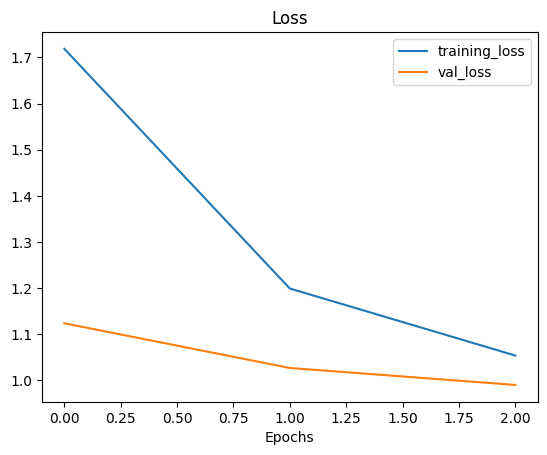

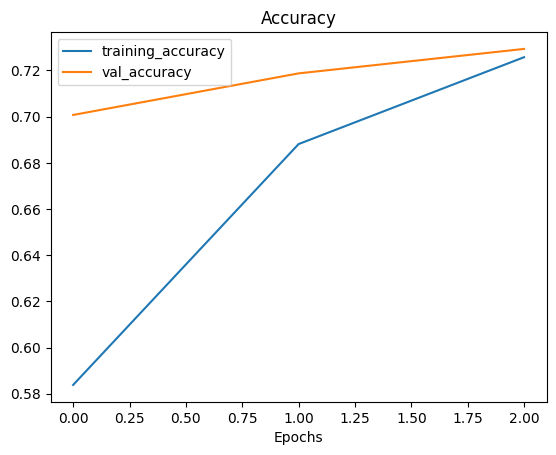

In [25]:
### Plotting training/ validation loss & accuracy

plot_loss_curve(first_model_history)

In [28]:
### Create model function to save hussle

def create_model():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
    base_model.trainable = False

    input_layer = layers.Input(shape = input_shape, name = "input_layer")
    ### Built-in rescaling for model, may include 
    # x = layers.Rescaling(1./ 255)(x)
    x = base_model(input_layer, training = False)
    x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)

    output_layer = layers.Dense(len(class_names), activation = "softmax")(x)
    
    model = tf.keras.Model(input_layer, output_layer)
  
    return model

Second model - EfficientNetB0 (Feature Extraction), load checkpoint weight

In [29]:
second_model = create_model()
second_model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

second_model.load_weights(checkpoint_path)

second_model_evaluation = second_model.evaluate(test_data)

790/790 [==============================] - 829s 1s/step - loss: 1.0035 - accuracy: 0.7256


In [33]:
### Check both evaluation result

np.isclose(first_model_evaluation, second_model_evaluation).all()

True

In [36]:
### Check second model first 20 layers of EfficientNetB0 

for layer in second_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "float32">
normalization_2 False float32 <Policy "float32">
rescaling_5 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [37]:
save_dir = "saved_model/cv/food_vision_big_project_first_model"
# os.makedirs(save_dir)

first_model.save(save_dir)

INFO:tensorflow:Assets written to: saved_model/cv/food_vision_big_project_first_model\assets


INFO:tensorflow:Assets written to: saved_model/cv/food_vision_big_project_first_model\assets


In [38]:
loaded_saved_first_model = tf.keras.models.load_model(save_dir)

for layer in loaded_saved_first_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
rescaling_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [39]:
result_loaded_saved_first_model = loaded_saved_first_model.evaluate(test_data)
result_loaded_saved_first_model

790/790 [==============================] - 811s 1s/step - loss: 1.0035 - accuracy: 0.7256


[1.003501296043396, 0.7256237864494324]

In [45]:
np.isclose(first_model_evaluation, result_loaded_saved_first_model).all()

True

Third model - EfficientNetB0 (Fine Tuning)

In [46]:
third_model = tf.keras.models.load_model("saved_model/cv/food_vision_big_project_first_model")

third_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [49]:
third_model_evaluation = third_model.evaluate(test_data)

third_model_evaluation

790/790 [==============================] - 834s 1s/step - loss: 1.0035 - accuracy: 0.7256


[1.0035022497177124, 0.7256237864494324]

In [54]:
for layer in third_model.layers:
    layer.trainable = True 
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">


In [55]:
for layer in third_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "float32">
normalization True float32 <Policy "float32">
rescaling_1 True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">
block1a_se_squeeze True float32 <Policy "float32">
block1a_se_reshape True float32 <Policy "float32">
block1a_se_reduce True float32 <Policy "float32">
block1a_se_expand True float32 <Policy "float32">
block1a_se_excite True float32 <Policy "float32">
block1a_project_conv True float32 <Policy "float32">
block1a_project_bn True float32 <Policy "float32">
block2a_expand_conv True float32 <Policy "float32">
block2a_expand_bn True float32 <Policy "float32">


In [59]:
### Apply overfitting preventation strategy

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3) 
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
    patience = 2, verbose = 1, min_lr = 1e-7)

checkpoint_path = "model_checkpoint/food_vision_big_project_first_model/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True,
    monitor = "val_loss")

In [60]:
third_model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = ["accuracy"])

third_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 4136929 (15.78 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [63]:
third_model_history = third_model.fit(train_data, epochs = 100, steps_per_epoch = len(train_data),
    validation_data = test_data, validation_steps = int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback("model_log", "efficientb0_101_classes_all_data_fine_tuning"),
        model_checkpoint, early_stopping, reduce_learning_rate])

Saving TensorBoard log files to: model_log/efficientb0_101_classes_all_data_fine_tuning/20230929-230002
Epoch 1/100
   8/2368 [..............................] - ETA: 2:36:30 - loss: 1.1166 - accuracy: 0.7031

KeyboardInterrupt: 